In [2]:

!pip install opencv-contrib-python moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy
!pip install pafy
!pip install tensorflow
!pip install matplotlib
!pip install -U scikit-learn
!pip install -U ipython
!pip install pytube
!pip install mediapipe
!pip install pandas
!pip install openpyxl
!pip install --upgrade yt-dlp

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/TahaAnwar/pafy.git to c:\users\admin\appdata\local\temp\pip-install-rleexfsq\pafy_9ce0473b7f8d48c58d8a9418eed91228
  Resolved https://github.com/TahaAnwar/pafy.git to commit 2f3c473b3df7961721d07e1504675313afd1d2cb
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/TahaAnwar/pafy.git 'C:\Users\ADMIN\AppData\Local\Temp\pip-install-rleexfsq\pafy_9ce0473b7f8d48c58d8a9418eed91228'


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached ml_dtypes-0.3.2-cp312-cp312-win_amd64.whl.metadata (20 kB)
Using cached ml_dtypes-0.3.2-cp312-cp312-win_amd64.whl (128 kB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.4.29 requires ml-dtypes>=0.4.0, but you have ml-dtypes 0.3.2 which is incompatible.
jaxlib 0.4.29 requires ml-dtypes>=0.4.0, but you have ml-dtypes 0.3.2 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached ml_dtypes-0.4.0-cp312-cp312-win_amd64.whl.metadata (20 kB)
Using cached ml_dtypes-0.4.0-cp312-cp312-win_amd64.whl (127 kB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.16.1 requires ml-dtypes~=0.3.1, but you have ml-dtypes 0.4.0 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:

import os
import yt_dlp
import cv2
import pafy
import math
import random
import pydot
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from pytube import YouTube
import time
import mediapipe as mp
from IPython.display import Video, HTML
from moviepy.editor import VideoFileClip
import pandas as pd
import openpyxl 

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:

IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "Unpolished_Gems"
CLASSES_LIST = ["JumpingJack", "JumpRope", "Lunges","PushUps"]

In [6]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

In [7]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    features = np.asarray(features)
    labels = np.array(labels)  
    return features, labels, video_files_paths

In [8]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: JumpingJack
Extracting Data of Class: JumpRope
Extracting Data of Class: Lunges
Extracting Data of Class: PushUps


In [9]:
one_hot_encoded_labels = to_categorical(labels)

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.3, shuffle = True,
                                                                            random_state = seed_constant)

#LRCN model

In [11]:
def create_LRCN_model():
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
    model.summary()
    return model

In [12]:
LRCN_model = create_LRCN_model()
print("Model Created Successfully!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


#check Model


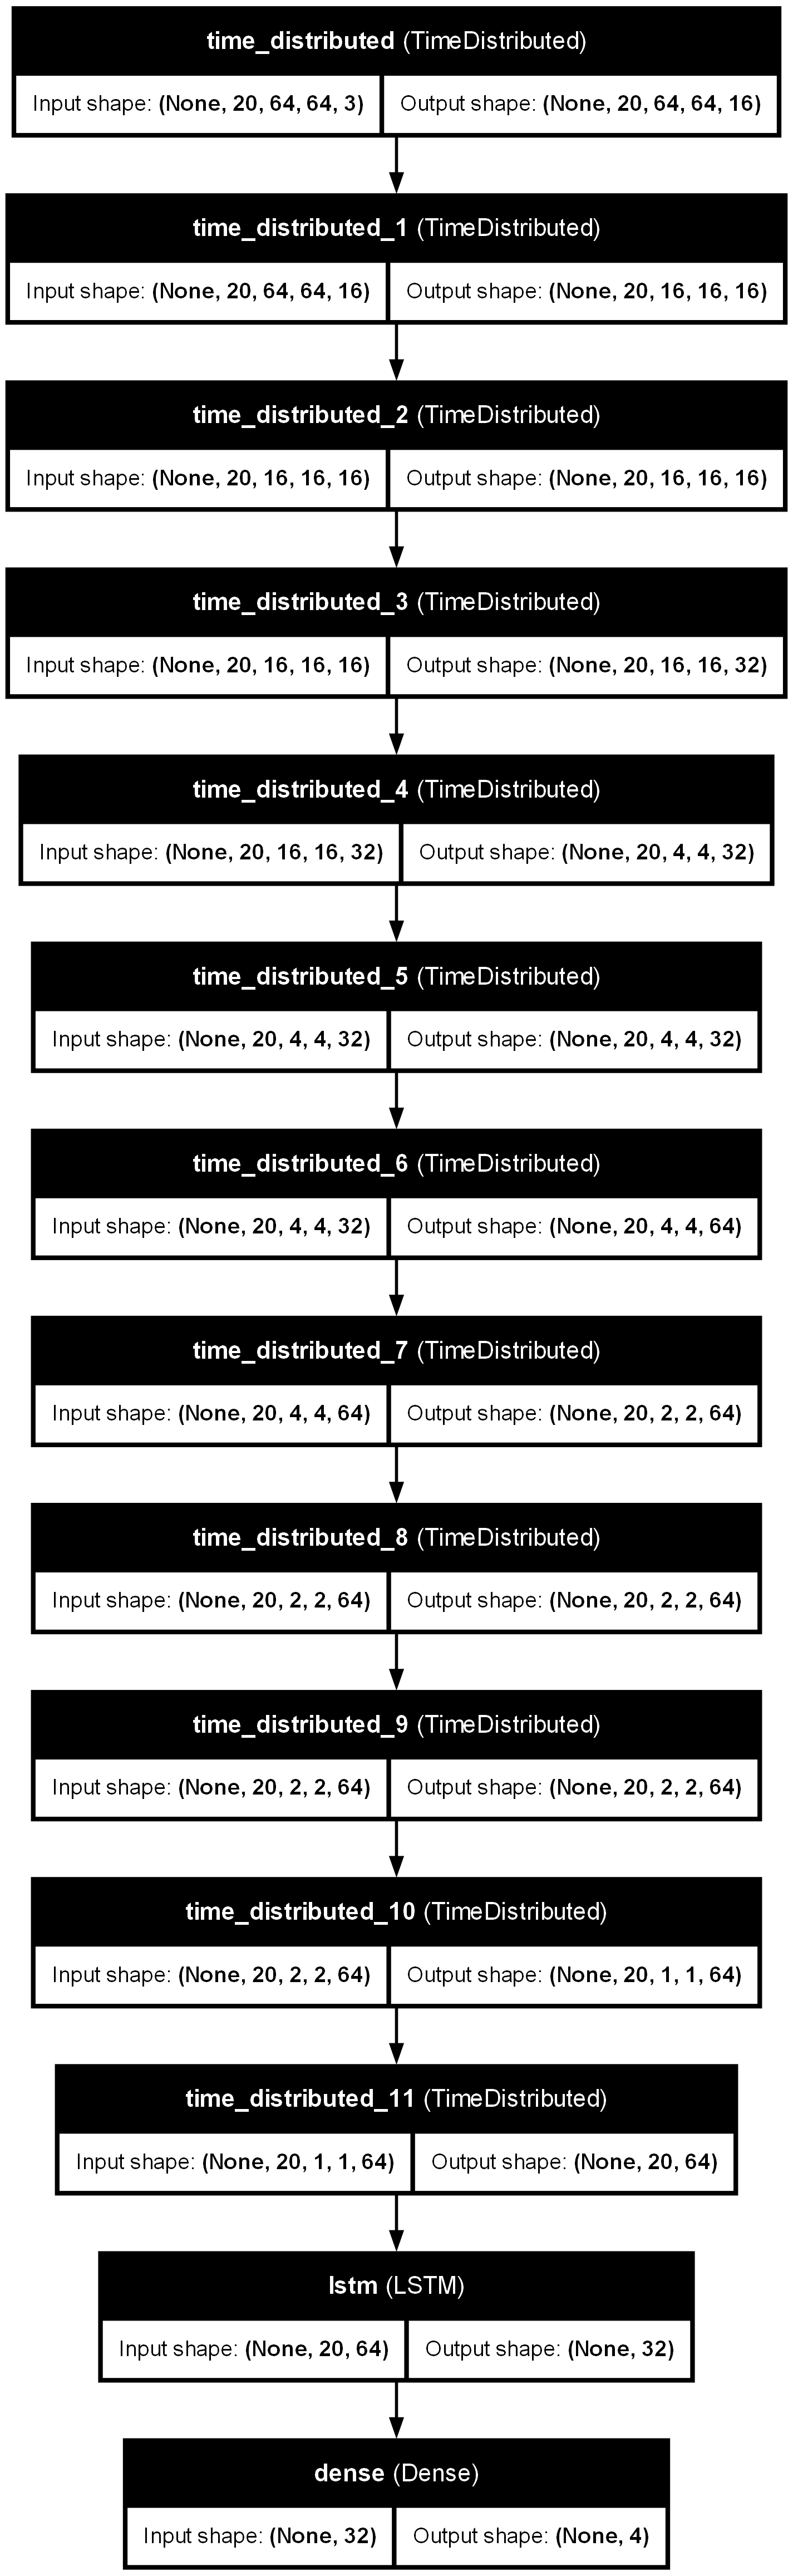

In [12]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [13]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 100, batch_size = 64 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.2827 - loss: 1.3866 - val_accuracy: 0.2263 - val_loss: 1.3765
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 967ms/step - accuracy: 0.3328 - loss: 1.3455 - val_accuracy: 0.2847 - val_loss: 1.3630
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 944ms/step - accuracy: 0.3481 - loss: 1.3343 - val_accuracy: 0.3942 - val_loss: 1.3371
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 951ms/step - accuracy: 0.3926 - loss: 1.2865 - val_accuracy: 0.3796 - val_loss: 1.2930
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 948ms/step - accuracy: 0.3890 - loss: 1.2703 - val_accuracy: 0.3504 - val_loss: 1.2535
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 940ms/step - accuracy: 0.3873 - loss: 1.2237 - val_accuracy: 0.4161 - val_loss: 1.2170
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 956ms/step - accuracy: 0.4887 - loss: 1.1777 - val_accuracy: 0.4964 - val_loss: 1.1828
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 940ms/step - accuracy: 0.4983 - loss: 1.1456 - val_accuracy: 0.4964 - val

In [14]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9511 - loss: 0.1875


In [15]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
LRCN_model.save('my_model.keras')

In [16]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))
    plt.legend()

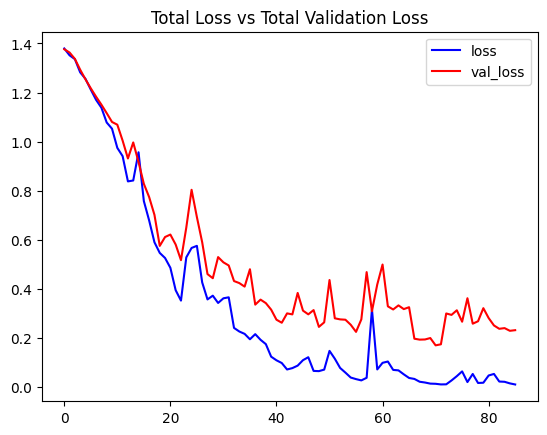

In [17]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

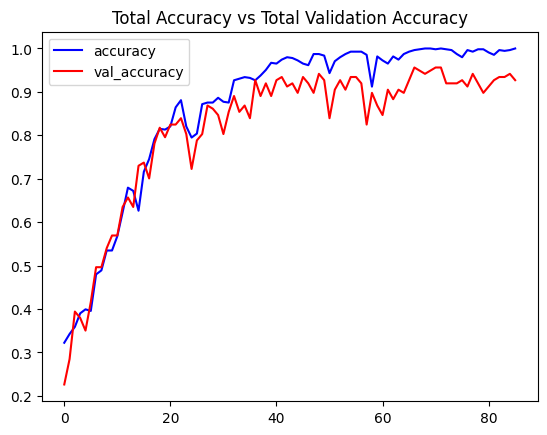

In [18]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

#Predict on video

In [38]:

def download_youtube_videos(youtube_video_url, output_directory):

    ydl_opts = {'outtmpl': f'{output_directory}/%(title)s.%(ext)s'}
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(youtube_video_url, download=True)
        title = info['title']
    return title
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)
video_title = download_youtube_videos('https://studio.youtube.com/video/PGSr7UZazDY/edit', test_videos_directory)
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

[youtube] Extracting URL: https://www.youtube.com/watch?v=2CUyDdztieE
[youtube] 2CUyDdztieE: Downloading webpage
[youtube] 2CUyDdztieE: Downloading ios player API JSON
[youtube] 2CUyDdztieE: Downloading m3u8 information


[info] 2CUyDdztieE: Downloading 1 format(s): 18
[download] test_videos\JUMPING JACKS.mp4 has already been downloaded
[download] 100% of  322.94KiB


In [20]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
    predicted_class_name = ''
    while video_reader.isOpened():
        ok, frame = video_reader.read() 
        if not ok:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)
        if len(frames_queue) == SEQUENCE_LENGTH:

            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        video_writer.write(frame)
    video_reader.release()
    video_writer.release()

In [39]:
video_path = '__temp__.mp4'
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
video_clip = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None))
video_clip.ipython_display(maxduration=video_clip.duration + 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [21]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames_list = []    

    predicted_class_name = ''

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read() 

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
     
        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    predicted_label = np.argmax(predicted_labels_probabilities)

    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    wb = openpyxl.load_workbook('output.xlsx')
    ws = wb.active

    next_row = ws.max_row + 1

    ws.cell(row=next_row, column=1).value = 'Action Predicted'
    ws.cell(row=next_row, column=2).value = predicted_class_name

    wb.save('output.xlsx')

    os.startfile('output.xlsx')
    
    video_reader.release()


In [43]:
video_title = download_youtube_videos('https://www.youtube.com/watch?v=2znzDJXTEWg', test_videos_directory)

input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

[youtube] Extracting URL: https://www.youtube.com/watch?v=2znzDJXTEWg
[youtube] 2znzDJXTEWg: Downloading webpage
[youtube] 2znzDJXTEWg: Downloading ios player API JSON
[youtube] 2znzDJXTEWg: Downloading m3u8 information


[info] 2znzDJXTEWg: Downloading 1 format(s): 18
[download] test_videos\lunges7m-7.mp4 has already been downloaded
[download] 100% of  189.61KiB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Action Predicted: JumpRope
Confidence: 0.984584391117096
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
